# Excercises

In [1]:
# imports
from IPython.display import Image as showImage
from os import getcwd, path
import numpy as np
from math import fabs, pi, sin, cos
import matplotlib.pyplot as plt
from Imports import warping
from PIL import Image
from scipy.ndimage import convolve
from scipy.signal import sepfir2d
from time import sleep
from IPython.display import clear_output as clearImage

In [2]:
# directories
cw_dir = getcwd()
image_dir = path.join(cw_dir, 'Images')

## Excercise 1

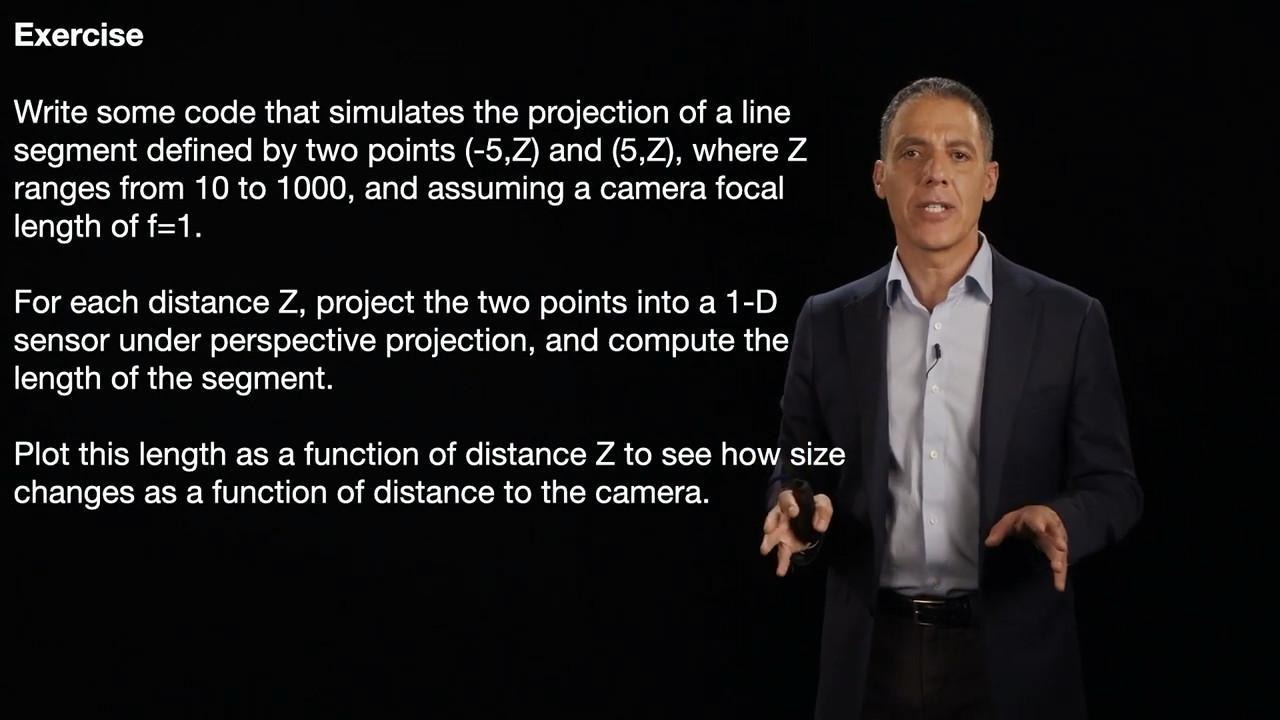

In [3]:
# question
showImage(path.join(image_dir, 'Excercise1.jpg'))

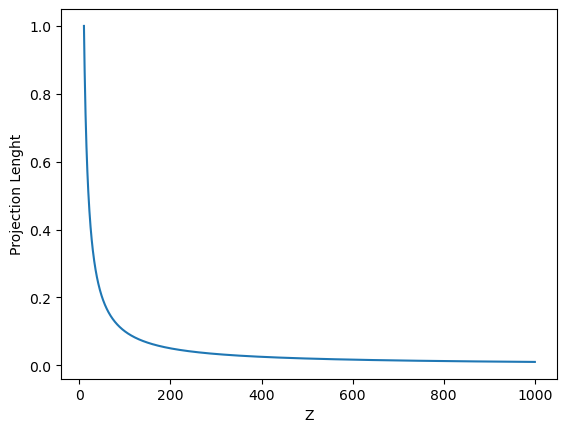

In [4]:
# answer

focal_length = 1

z_start = 10
z_stop = 1000
step_per_unit = 2
samples = (z_stop - z_start) * step_per_unit
Z = np.linspace(z_start, z_stop, samples, endpoint=True)

x_start = 5
x_stop = -5

p_lengths = []
for z_sample in Z:
    P1 = (x_start, z_sample)
    P2 = (x_stop, z_sample)

    # calculate coordinate on sensor
    p1 = - focal_length * P1[0] / P1[1]
    p2 = - focal_length * P2[0] / P2[1]

    # calculate projection length
    p_length = fabs(p2 - p1)
    p_lengths.append(p_length)

plt.plot(Z, p_lengths)
plt.xlabel('Z')
plt.ylabel('Projection Lenght')
plt.show()

## Excercise 2

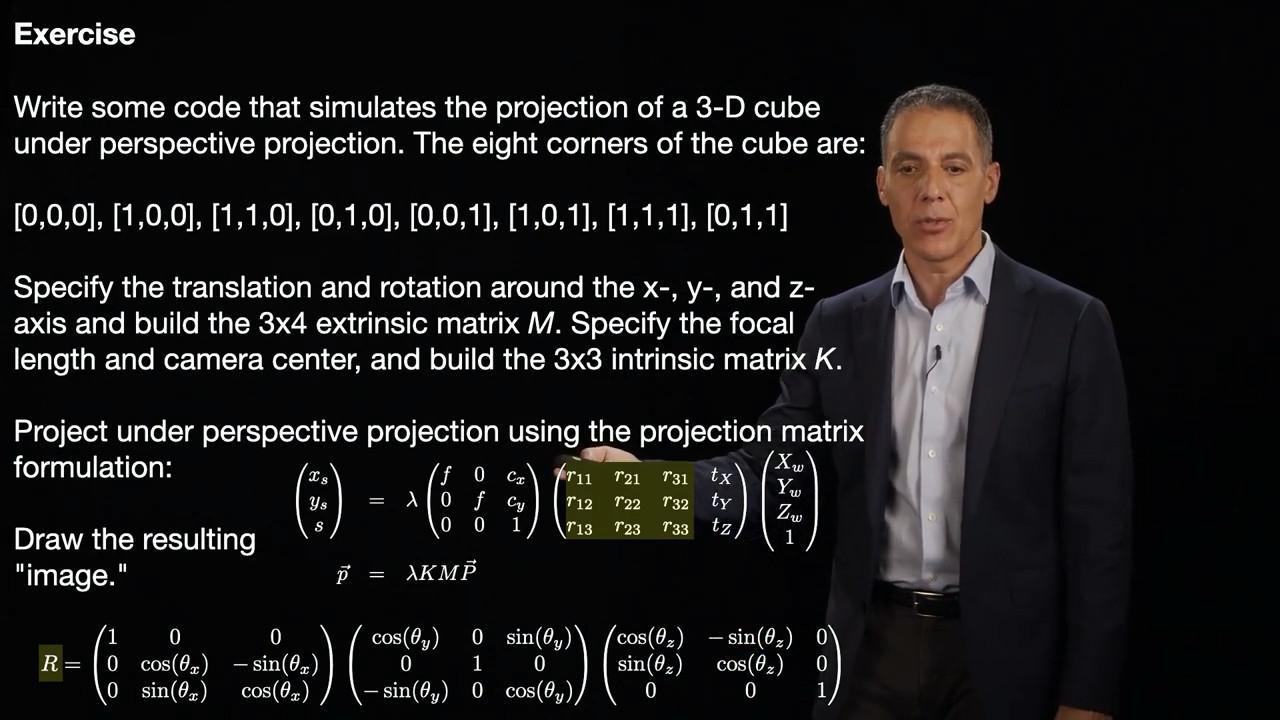

In [5]:
# question
showImage(path.join(image_dir, 'Excercise2.jpg'))

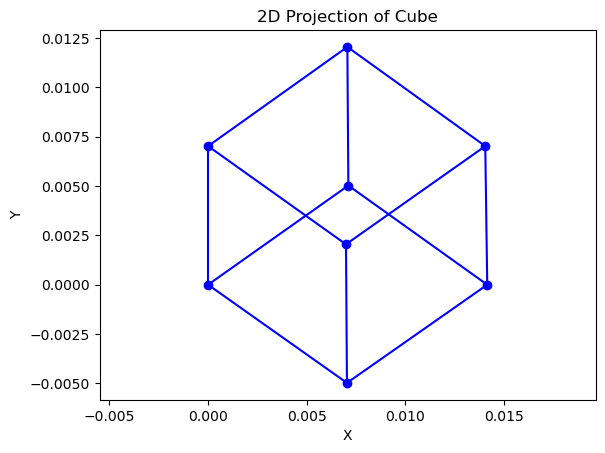

In [6]:
# answer

cube = np.array([[0,0,0], [1,0,0], [1,1,0], [0,1,0], [0,0,1], [1,0,1], [1,1,1], [0,1,1]]) # eight corners of the cube

lamda = 1 # pixel/unit

f = 1 # focal length
c_x, c_y = 0, 0 # origin offset
K = np.array([[f, 0, c_x], [0, f, c_y], [0, 0, 1]]) # intrinsic matrix

# rotation around each axis
theta_x = pi/4
theta_y = pi/4
theta_z = 0

# rotation matrix for each axis
R_x = np.array([[1,0,0], [0, cos(theta_x), -sin(theta_x)], [0, sin(theta_x), cos(theta_x)]])
R_y = np.array([[cos(theta_y), 0, sin(theta_y)], [0,1,0], [-sin(theta_y), 0, cos(theta_y)]])
R_z = np.array([[cos(theta_z), -sin(theta_z), 0], [sin(theta_z), cos(theta_z), 0], [0,0,1]])

# 3x3 rotation matrix 
R = R_x @ R_y @ R_z

# translation vector
t_x, t_y, t_z = 0, 0, 100
t_vec = np.array([[t_x, t_y, t_z]]).T

# construct extrinsic matrix
M = np.hstack((R, t_vec))

# calculate projection for each corner in cube
points = []
for corner in cube:
    X_w, Y_w, Z_w = corner
    P = np.array([[X_w, Y_w, Z_w, 1]]).T # Point in homogeneous world coordinates
    p = lamda * K @ M @ P # point in homogeneous camera coordinates
    x_s, y_s, s = p
    x = x_s/s
    y = y_s/s
    points.append((x,y))

vertices = points[0:]

# define the edges connecting the vertices
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
    (4, 5), (5, 6), (6, 7), (7, 4),  # top face
    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
]

# plot the edges
for edge in edges:
    x_coords = [vertices[edge[0]][0], vertices[edge[1]][0]]
    y_coords = [vertices[edge[0]][1], vertices[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='blue')

# highlight the vertices
x, y = zip(*vertices)
plt.scatter(x, y, color='blue')

# customize the plot
plt.axis('equal')  # equal aspect ratio for proper scaling
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Projection of Cube")
plt.show()

## Excercise 3

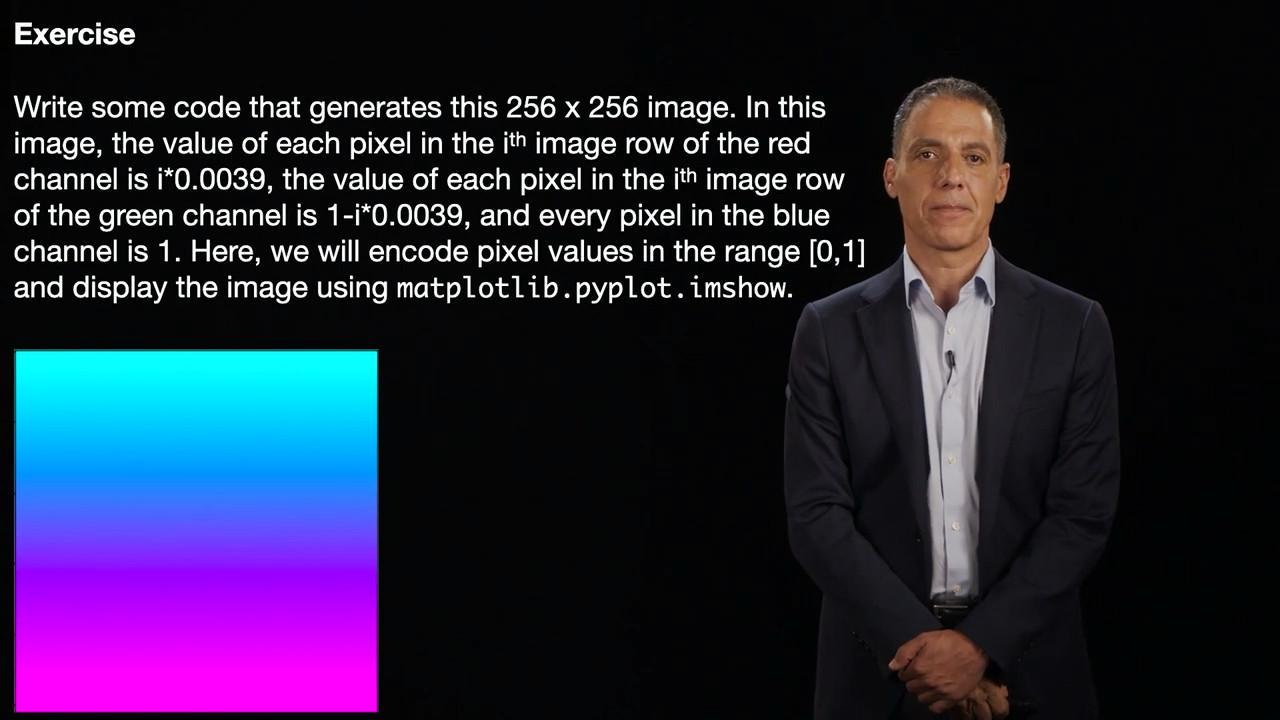

In [7]:
# question
showImage(path.join(image_dir, 'Excercise3.jpg'))

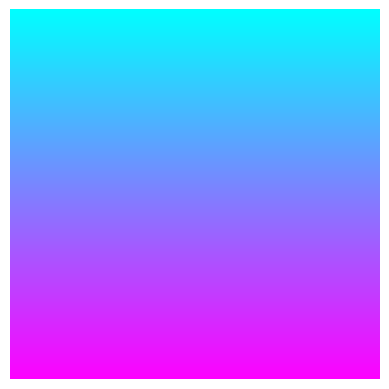

In [8]:
# answer

dim = (256, 256) # dimension of the image

# initialize each color channel
r_channel = np.zeros(dim)
g_channel = np.zeros(dim)
b_channel = np.zeros(dim)

# assign each pixel value
for i in range(dim[0]): # for each row in image
    r_channel[i,:] = i * 0.0039
    g_channel[i,:] = 1 - i * 0.0039
    b_channel[i,:] = 1

# crate RGB image
rgb_image = np.stack((r_channel, g_channel, b_channel), axis=-1)

# display the RGB image
plt.imshow(rgb_image)
plt.axis('off')  # hide the axis for a cleaner display
plt.show()

## Excercise 4

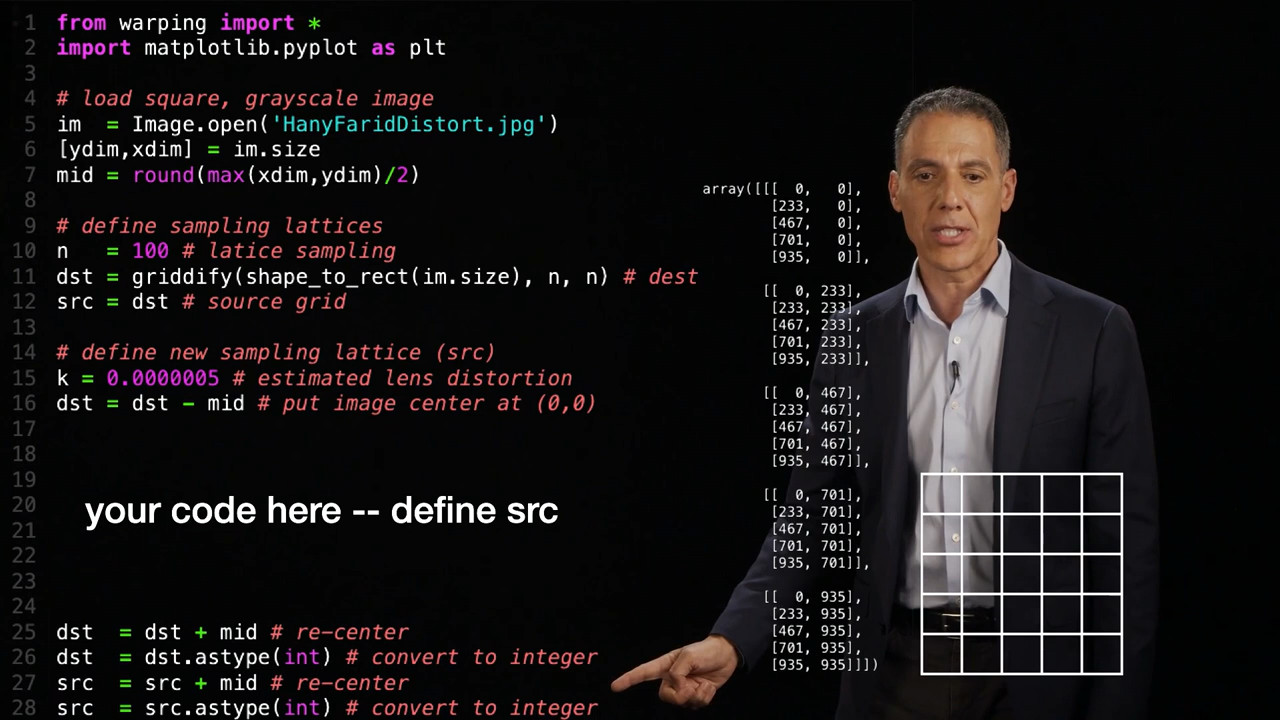

In [9]:
# question
showImage(path.join(image_dir, 'Excercise4.jpg'))

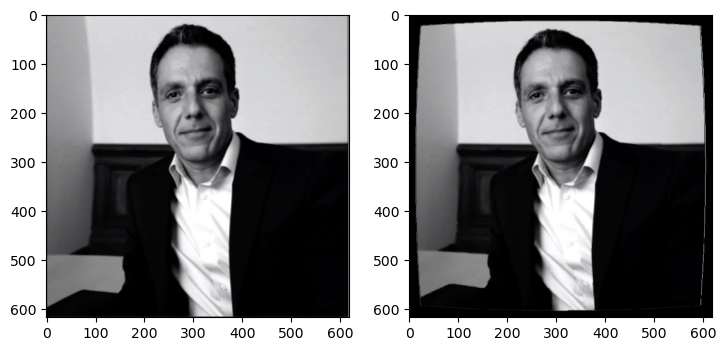

In [10]:
# answer

im = Image.open('Images/HanyFaridDistort.png') # load square, grayscale image 
[ydim,xdim] = im.size
mid = round(max(xdim,ydim)/2)

# define sampling lattices
n = 100 # latice sampling
dst = warping.griddify(warping.shape_to_rect(im.size), n, n) # destination grid
src = dst # source grid

# define new sampling lattice (src)
k = 0.0000005 # estimated lens distortion
dst = dst - mid # put image center at (0,0)

for i in range(n+1):
    for j in range(n+1):
        x = dst[i, j, 0]
        y = dst[i, j, 1]
        r = np.sqrt(x**2 + y**2)
        src[i, j, 0] = x * (1 + k * r**2)
        src[i, j, 1] = y * (1 + k * r**2)
        
dst = dst + mid # re-center
src = src + mid # re-center

# warp image 
mesh = warping.grid_to_mesh(src, dst) # define mesh
imt = im.transform(im.size, Image.MESH, mesh) # warp
plt.figure(figsize=(ydim/72, xdim/72))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(imt, cmap='gray')
plt.show()

## Excercise 5

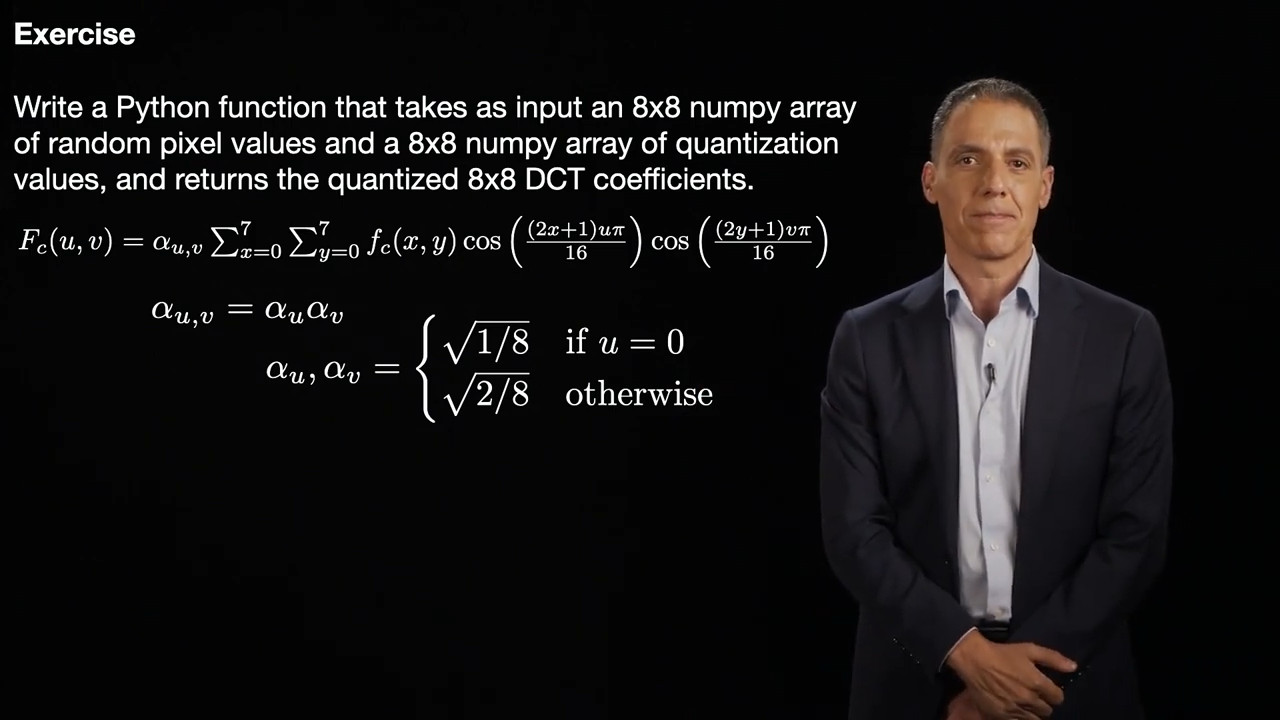

In [11]:
# question
showImage(path.join(image_dir, 'Excercise5.jpg'))

In [12]:
# answer

dim = (8, 8)
pixel_values = np.random.rand(*dim) * 255
quantization_values = np.ones(dim) * 2

def get_pixel_value(i, j):
    return pixel_values[i][j]

def calc_coeff(u, v):
    alpha_u = alpha_v = np.sqrt(1/8) if u==0 else np.sqrt(2/8)
    alpha = alpha_u * alpha_v

    sum = 0
    for x in range(dim[1]):
        for y in range(dim[1]):
           sum +=  get_pixel_value(x, y) * np.cos(((2*x + 1)* u * np.pi)/16) * np.cos(((2*y + 1)* v * np.pi)/16)

    return alpha * sum

coeffs = np.array([calc_coeff(u,v) for u in range(dim[1]) for v in range(dim[1])]).reshape(dim)
coeffs = np.array(coeffs/quantization_values, dtype=int)

coeffs

array([[524,  -7,  48,  19,  -5,   8,   8, -20],
       [-23, -26, -19,  38,   9,  25, -11, -36],
       [-52,  87, -36, -37, -45, -41,  -3, -44],
       [-37, -37,  27,  26,  67, -22,  -1,  41],
       [-65,  -2,  -6, -38,  58, -41,  -8,  75],
       [ 34, -18,  -6, -40,   2,   3,  22,  66],
       [ -4, -18,  20,  51,  80, -47,  50, -18],
       [-20,  47,  68,   3,  -6,  40, -12,   3]])

## Excercise 6

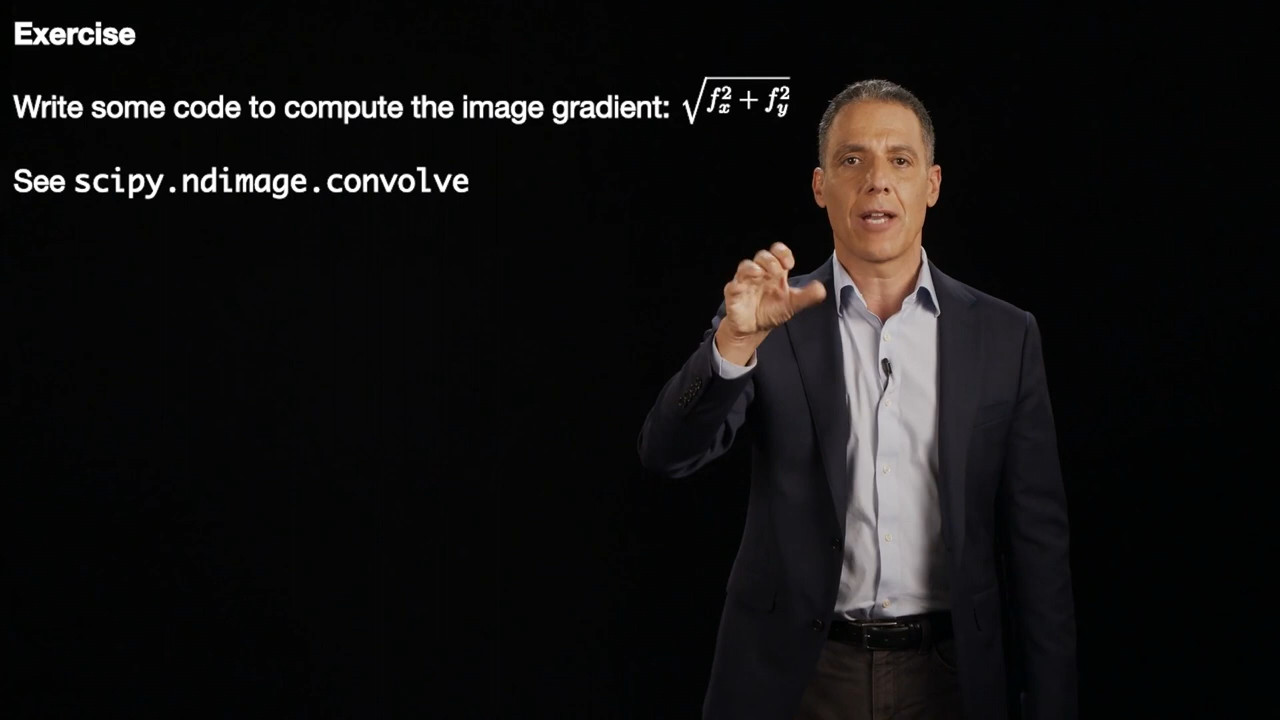

In [13]:
# question
showImage(path.join(image_dir, 'Excercise6.jpg'))

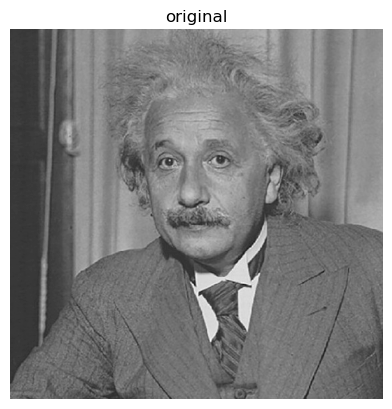

In [14]:
# answer

original = Image.open('Images/Einstein.jpg') # load the original image
original = np.array(original)
original = np.average(original, axis=-1)
plt.imshow(original , cmap='gray')
plt.title('original')
plt.axis('off')
plt.show()

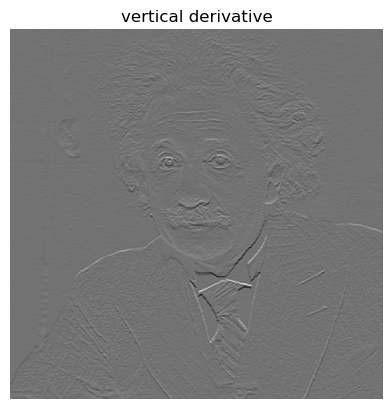

In [15]:
# vertical derivative 
v_filter = np.array([[-0.125,-0.250,-0.125],[0,0,0],[0.125,0.250,0.125]])
v_image = convolve(original, v_filter, mode='reflect')

plt.imshow(v_image , cmap='gray')
plt.title('vertical derivative')
plt.axis('off')
plt.show()

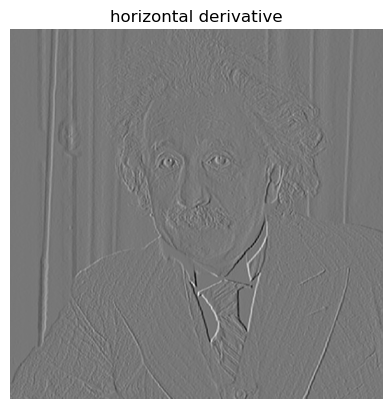

In [16]:
# horizontal derivative 
h_filter = np.array([[-0.125,0,0.125],[-0.25,0,.25],[-0.125,0,0.125]])
h_image = convolve(original, h_filter, mode='reflect')

plt.imshow(h_image , cmap='gray')
plt.title('horizontal derivative')
plt.axis('off')
plt.show()

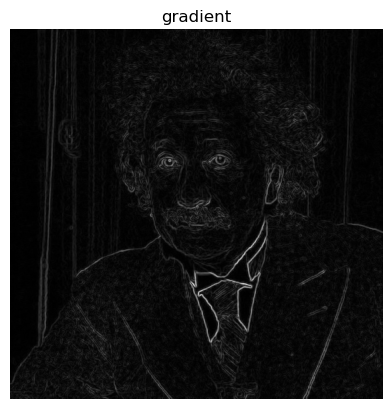

In [17]:
# gradient
g_image = np.sqrt(v_image**2 + h_image**2)

plt.imshow(g_image , cmap='gray')
plt.title('gradient')
plt.axis('off')
plt.show()

## Excercise 7

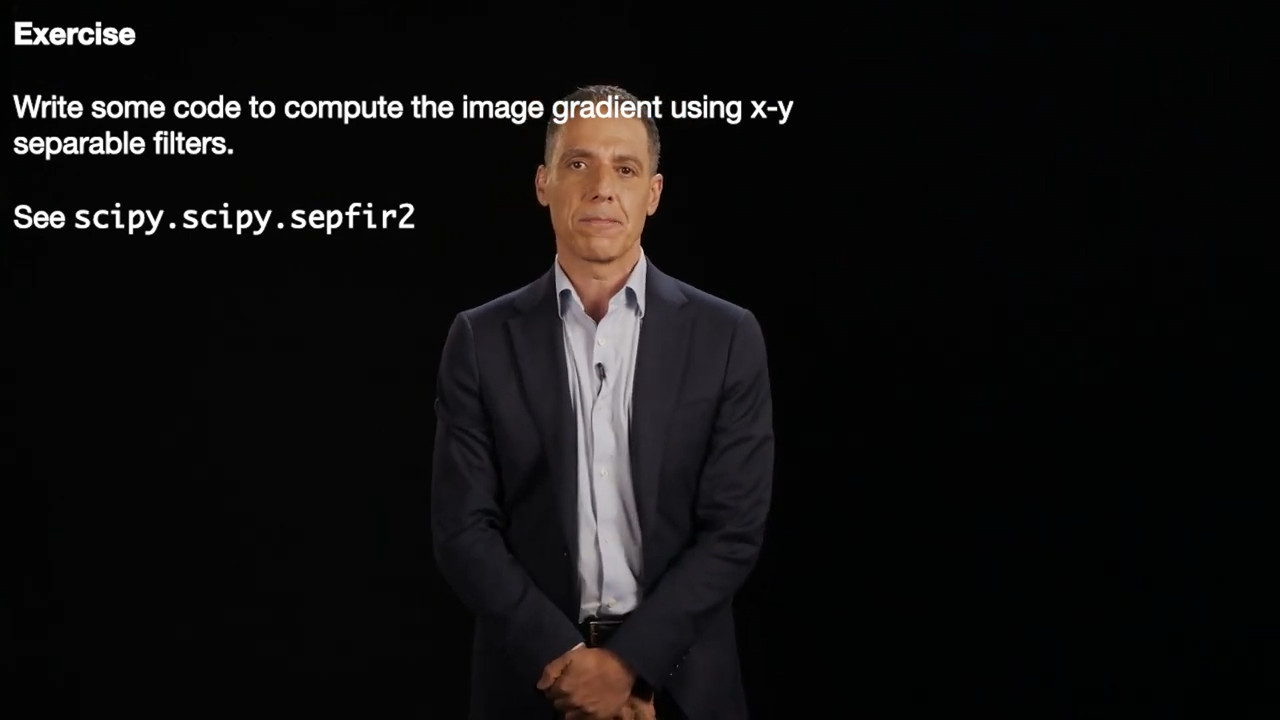

In [18]:
# question
showImage(path.join(image_dir, 'Excercise7.jpg'))

[-0.70710678  0.          0.70710678]
[0.40824829 0.81649658 0.40824829]


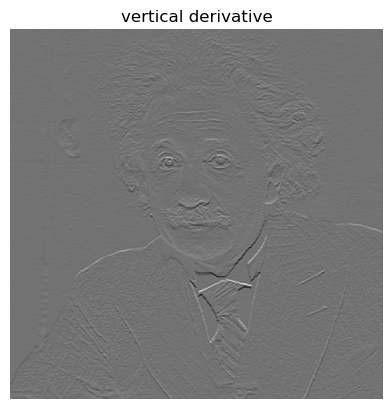

In [19]:
# answer

# vertical derivative 
v_filter = np.array([[-0.125,-0.250,-0.125],[0,0,0],[0.125,0.250,0.125]]) 
v_filter_U, v_filter_S, v_filter_V = np.linalg.svd(v_filter)

print(v_filter_U[:,0])
print(v_filter_V[0])

v_image_sep = sepfir2d(original, v_filter_V[0], v_filter_U[:,0])

plt.imshow(v_image_sep , cmap='gray')
plt.title('vertical derivative')
plt.axis('off')
plt.show()

[-0.40824829 -0.81649658 -0.40824829]
[ 0.70710678  0.         -0.70710678]


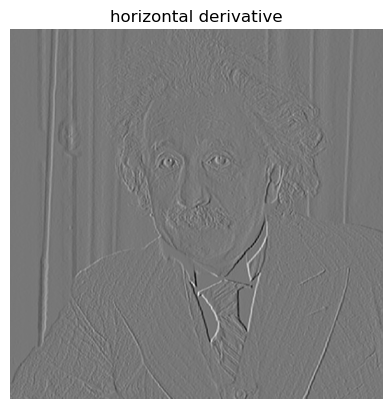

In [20]:
# horizontal derivative 
h_filter = np.array([[-0.125,0,0.125],[-0.25,0,.25],[-0.125,0,0.125]])
h_filter_U, h_filter_S, h_filter_V = np.linalg.svd(h_filter)


print(h_filter_U[:,0])
print(h_filter_V[0])

h_image_sep = sepfir2d(original, h_filter_V[0], h_filter_U[:,0])

plt.imshow(h_image_sep , cmap='gray')
plt.title('horizontal derivative')
plt.axis('off')
plt.show()

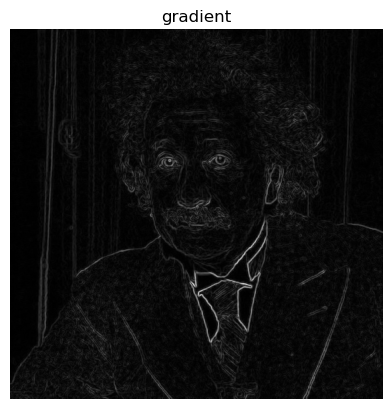

In [21]:
# gradient
g_image_sep = np.sqrt(v_image_sep**2 + h_image_sep**2)

plt.imshow(g_image_sep , cmap='gray')
plt.title('gradient')
plt.axis('off')
plt.show()

## Excercise 8

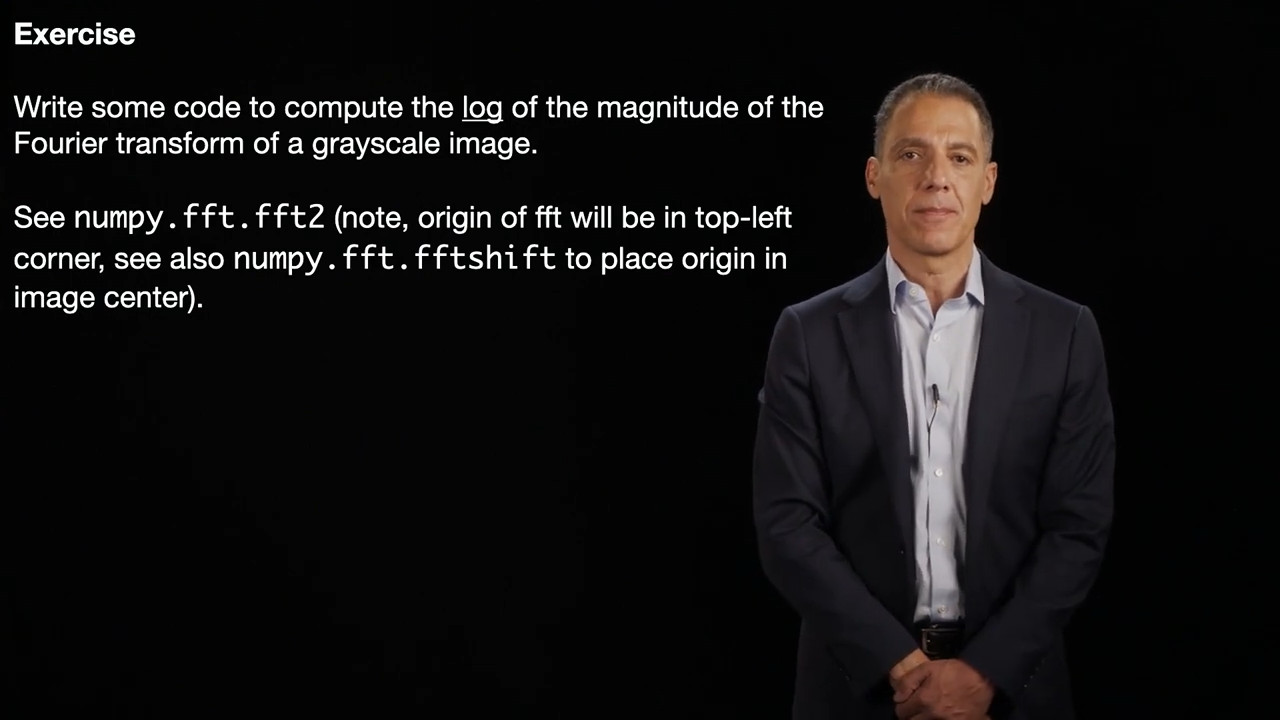

In [22]:
# question
showImage(path.join(image_dir, 'Excercise8.jpg'))

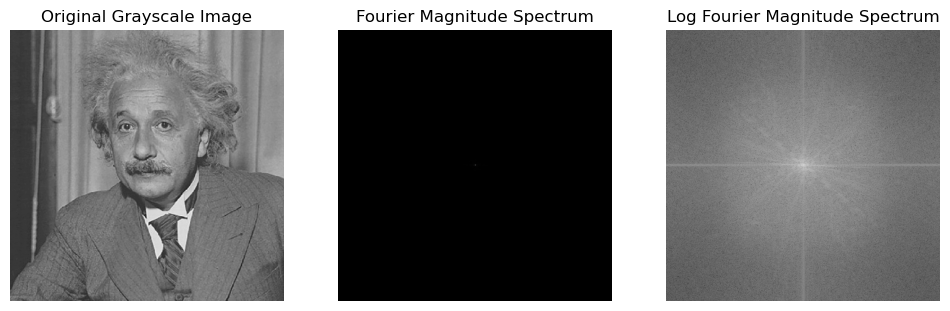

In [23]:
# answer

einstein = Image.open('Images/Einstein.jpg').convert('L')  # load the einstein image as grayscale
img_array = np.array(einstein)

# 2D Fourier Transform
f_transform = np.fft.fft2(img_array)

# Shift the zero-frequency component to the center
f_shifted = np.fft.fftshift(f_transform)

# Compute the magnitude
magnitude_spectrum = np.abs(f_shifted)
log_magnitude_spectrum = np.log(np.abs(f_shifted))

# Display the original image and its magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier Magnitude Spectrum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title("Log Fourier Magnitude Spectrum")
plt.axis('off')

plt.show()

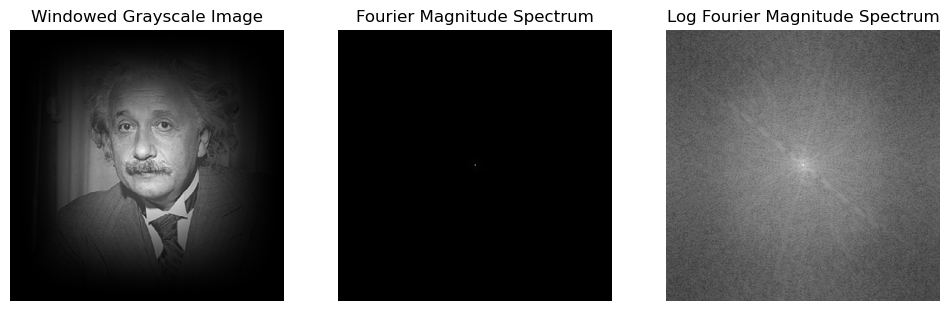

In [24]:
# windowed version to get rid of the horizontal and vertical artifacts 

[ydim, xdim] = img_array.shape # get the shape if the image
win = np.outer(np.hanning(ydim), np.hanning(xdim)) # create a 2D hanning window
win /= np.mean(win) # make window uint-mean

# 2D Fourier Transform
f_transform = np.fft.fft2(img_array*win) # Fourier transform on the windowed image

# Shift the zero-frequency component to the center
f_shifted = np.fft.fftshift(f_transform)

# Compute the magnitude
magnitude_spectrum = np.abs(f_shifted)
log_magnitude_spectrum = np.log(np.abs(f_shifted))

# Display the original image and its magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_array*win, cmap='gray')
plt.title("Windowed Grayscale Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Fourier Magnitude Spectrum")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(log_magnitude_spectrum, cmap='gray')
plt.title("Log Fourier Magnitude Spectrum")
plt.axis('off')

plt.show()

## Excercise 9

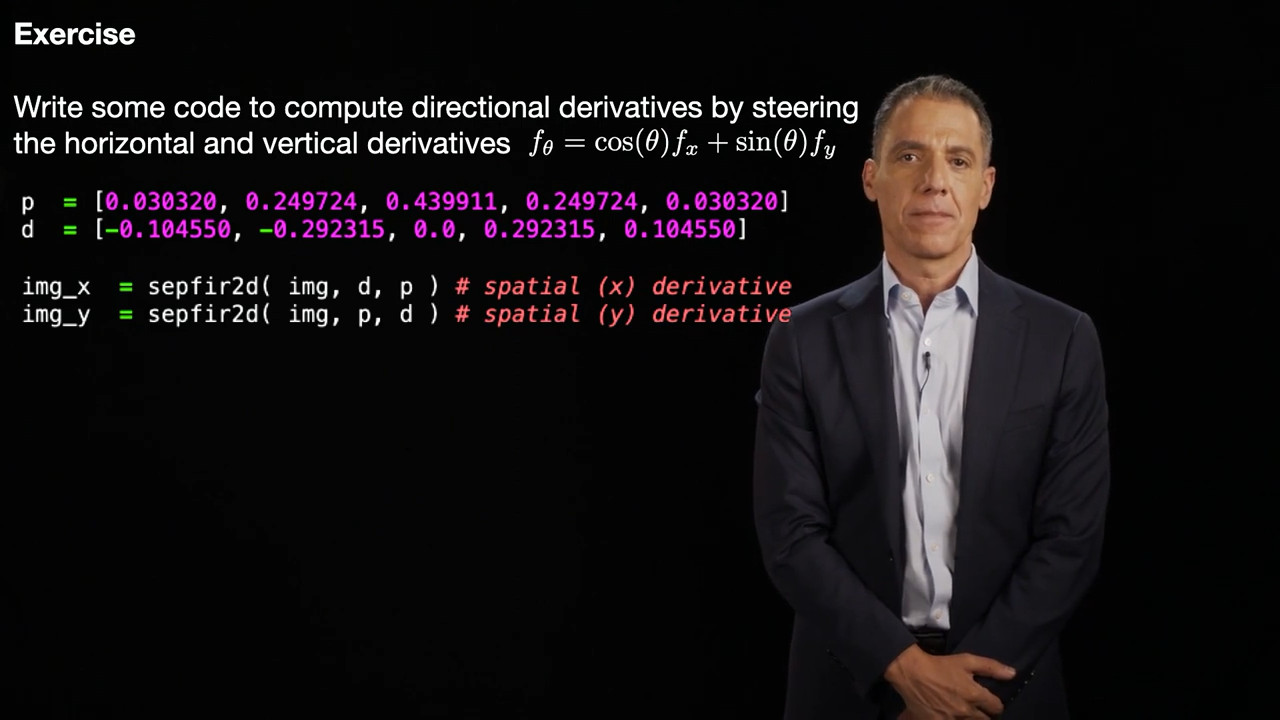

In [25]:
# question
showImage(path.join(image_dir, 'Excercise9.jpg'))

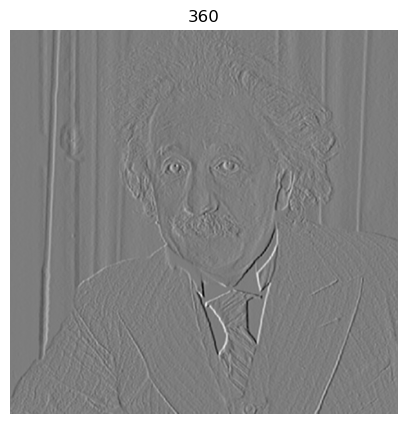

In [26]:
# answer

einstein = Image.open('Images/Einstein.jpg').convert('L')  # load the einstein image as grayscale
img = np.array(einstein)

p = [0.030320, 0.249724, 0.439911, 0.249724, 0.030320]
d = [-0.104550, -0.292315, 0.0, 0.292315, 0.104550]

img_x = sepfir2d(img, d, p) # spatial (x) derivative
img_y = sepfir2d(img, p, d) # spatial (y) derivative

images = []
for theta in range(0, 360 + 1, 10):
    angle_deg = np.radians(theta)
    _img = np.cos(angle_deg)*img_x + np.sin(angle_deg)*img_y
    images.append((_img, theta))

def slideShow():
    for _img, deg in images:
        plt.figure(figsize=(5,5))
        plt.imshow(_img , cmap='gray')
        plt.title(deg)
        plt.axis('off')
        plt.show()
        sleep(0.1)
        clearImage(wait=True)


slideShow()